### Energy Adjusted CBECI 

This script leverages the output of the accompagnying data generation script to interpolate CBECI estimates for varying electricity prices downloaded from the EIA (US Energy Information Administration). 

The motivation for this script is that the Cambridge Bitcoin Electricity Consumption Index assumes a constant fixed energy cost of $0.05/kWh, but in the face of rising energy prices there is desire to modify the output of the index to be more reflective of dynamic energy prices.


- Author: [Data Always](dataalways.substack.com)
- Last Modified: November 13, 2022
- Last Run: November 23, 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(
    rc={
        "figure.figsize":(10, 6.5), 
        "figure.subplot.left":0.10,
        "figure.subplot.right":0.95,
        "figure.subplot.top":0.92,
    }
) # Standardized figure formatting

start_date = '2013-01-01'
# First date of interest for the data

In [2]:
## Load in the electricity data 

df_source = pd.read_csv(
    './datasets/Average_retail_price_of_electricity.csv', 
    skiprows=4
) # Load in the electricity data

# Format and clean the electricity dataset
df = df_source.T
df.columns = df.iloc[0]
df.drop([
    'description', 
    'units', 
    'source key'], 
    inplace=True
) # Drop unwanted columns

df = df.dropna(axis=1)

df['date'] = [pd.to_datetime(x, format="%b %Y") for x in df.index]
# Convert the date inputs to pandas datetimes

In [3]:
## Load in and clean the cambridge dataset

df_cambridge = pd.read_csv(
    f"./datasets/cbeci-annualized-consumption.csv"
) # Load in the cambridge data generated by the sister script

df_cambridge['date'] = [pd.to_datetime(x) for x in df_cambridge['date']]
# Convert the date inputs to pandas datetimes

# Merge and sort the data
df = df.merge(df_cambridge, on="date", how="outer")
df = df.sort_values(by="date")

# The energy data is monthly, so we need to forward fill the gaps
df.fillna(method='ffill', inplace=True)

# Filter out data from before our interests
df = df[df['date'] > pd.to_datetime(start_date)]

# Reset the index for easier length-based calculations
df = df.reset_index()

In [4]:
df.head()

,index,United States : industrial,date,0.01,0.02,0.03,0.04,0.05,0.06,0.07,...,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19
0,1130,6.5,2013-01-02,0.446077,0.173960,0.173960,0.050701,0.050701,0.050701,0.050701,...,0.050701,0.050701,0.050701,0.050701,0.050701,0.050701,0.023960,0.013338,0.013338,0.013338
1,1131,6.5,2013-01-03,0.448493,0.174902,0.174902,0.050976,0.050976,0.050976,0.050976,...,0.050976,0.050976,0.050976,0.050976,0.050976,0.050976,0.029495,0.013410,0.013410,0.013410
2,1132,6.5,2013-01-04,0.442051,0.172390,0.172390,0.050244,0.050244,0.050244,0.050244,...,0.050244,0.050244,0.050244,0.050244,0.050244,0.050244,0.034462,0.013218,0.013218,0.013218
3,1133,6.5,2013-01-05,0.440843,0.171919,0.171919,0.050106,0.050106,0.050106,0.050106,...,0.050106,0.050106,0.050106,0.050106,0.050106,0.050106,0.039181,0.013182,0.013182,0.013182
4,1134,6.5,2013-01-06,0.432389,0.168622,0.168622,0.049146,0.049146,0.049146,0.049146,...,0.049146,0.049146,0.049146,0.049146,0.049146,0.049146,0.043818,0.012929,0.012929,0.012929


In [5]:
# Interpolate using the energy price (and a low-cost version at 75% price)
# from the energy price to the discrete values in the data set.

"""
Interpolate between the CBECI estimates based on the electricity input cost
"""
def calc_weighted(elec, indx):
    dist = elec % 1
    low = int(elec - dist + 0.1)
    high = low + 1
    
    low_str = "{:.2f}".format(low/100)
    high_str = "{:.2f}".format(high/100)
    return df[low_str][indx]*(1-dist) + df[high_str][indx]*dist

df['energy-adjusted'] = [calc_weighted(df['United States : industrial'][x], x) for x in np.arange(0, len(df))]
df['energy-adjusted-cheap'] = [calc_weighted(df['United States : industrial'][x]*0.73, x) for x in np.arange(0, len(df))]

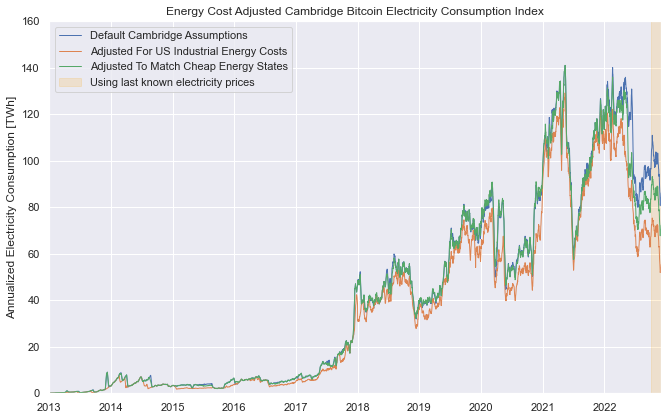

In [6]:
# Plot the interpolated data

sns.lineplot(
        x=df['date'], 
        y=df['0.05'],
        lw=1,
        label='Default Cambridge Assumptions'
) # The default Cambridge assumption is that energy costs are $0.05/kWh

sns.lineplot(
        x=df['date'], 
        y=df['energy-adjusted'],
        lw=1,
        label='Adjusted For US Industrial Energy Costs'
) # Data representing if all hash-rate was US and cost industrial prices

sns.lineplot(
        x=df['date'], 
        y=df['energy-adjusted-cheap'],
        lw=1,
        label='Adjusted To Match Cheap Energy States'
) # Data adjusted to broadly line up with historic CBECI estimates

plt.axvspan(
        xmin=pd.to_datetime(df_source.columns[-1])+pd.Timedelta(30, 'd'),
        xmax=df['date'][len(df)-1],
        color='orange',
        alpha=0.15,
        label='Using last known electricity prices'
) # Color the background for unknown electricity price data

plt.title('Energy Cost Adjusted Cambridge Bitcoin Electricity Consumption Index')
plt.ylabel('Annualized Electricity Consumption [TWh]')
plt.xlabel('') # Intentionally blank
plt.xlim([pd.to_datetime(start_date), df['date'][len(df)-1]])
plt.ylim([0, 160])
plt.legend()

plt.savefig(
        f'./tmp-figures/cbeci-adjusted.png', 
        transparent=False, 
        facecolor='w'
)
plt.show()

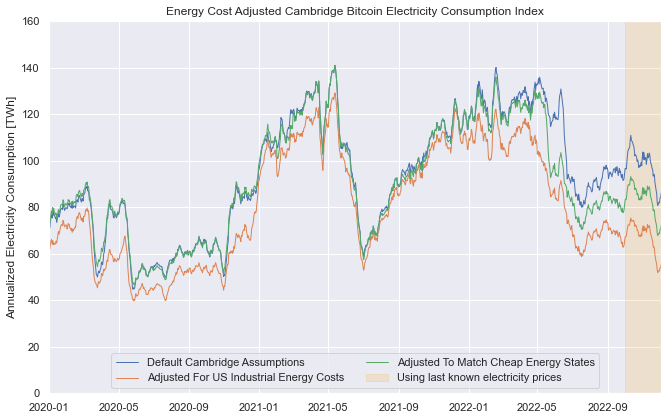

In [7]:
sns.lineplot(
        x=df['date'], 
        y=df['0.05'],
        lw=1,
        label='Default Cambridge Assumptions'
) # The default Cambridge assumption is that energy costs are $0.05/kWh

sns.lineplot(
        x=df['date'], 
        y=df['energy-adjusted'],
        lw=1,
        label='Adjusted For US Industrial Energy Costs'
) # Data representing if all hash-rate was US and cost industrial prices

sns.lineplot(
        x=df['date'], 
        y=df['energy-adjusted-cheap'],
        lw=1,
        label='Adjusted To Match Cheap Energy States'
) # Data adjusted to broadly line up with historic CBECI estimates

plt.axvspan(
        xmin=pd.to_datetime(df_source.columns[-1])+pd.Timedelta(30, 'd'),
        xmax=df['date'][len(df)-1],
        color='orange',
        alpha=0.15,
        label='Using last known electricity prices'
) # Color the background for unknown electricity price data

plt.title('Energy Cost Adjusted Cambridge Bitcoin Electricity Consumption Index')
plt.ylabel('Annualized Electricity Consumption [TWh]')
plt.xlabel('') # Intentionally blank
plt.xlim([pd.to_datetime('2020-01-01'), df['date'][len(df)-1]])
plt.ylim([0, 160])
plt.legend(
        ncol=2, 
        loc='lower center'
)

plt.savefig(
        f'./tmp-figures/cbeci-adjusted-recent.png', 
        transparent=False, 
        facecolor='w'
)

plt.show()

In [8]:
## Latest Estimates for network electricity usage

print(f"Last Cambridge Data Point: {df['date'][len(df['0.05'])-1]}")
print(f"Last EIA Data Point: {df_source.columns[-1]}")
print(f"Cambridge: {df['0.05'][len(df['0.05'])-1]:.4f} TWh per year")
print(f"US Industrial Average: {df['energy-adjusted'][len(df['energy-adjusted'])-1]:.4f} TWh per year")
print(f"US Cheap Average: {df['energy-adjusted-cheap'][len(df['energy-adjusted-cheap'])-1]:.4f} TWh per year")
print("-----------")
print(f"Cambridge Overestimate vs Cheap Average: {100*(1-df['energy-adjusted-cheap'][len(df['energy-adjusted-cheap'])-1]/df['0.05'][len(df['0.05'])-1]):.2f}%")

Last Cambridge Data Point: 2022-12-03 00:00:00
Last EIA Data Point: Sep 2022
Cambridge: 86.2163 TWh per year
US Industrial Average: 55.4242 TWh per year
US Cheap Average: 72.3097 TWh per year
-----------
Cambridge Overestimate vs Cheap Average: 16.13%
